Jupyter Notebook やJupyter Lab　を使うと、条件次第では死ぬほど時間がかかるので、早い動作を求めるならGoogle Colab推奨

まずは、ライブラリのインポートとオブジェクトの定義

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle

In [2]:
class Agent:
    def __init__(self, id, strategy=None, waight=None):
        self.id = id
        self.point_sum = 0
        self.point_last_time = 0
        self.cooporate = True
        self.strategy = ""
        self.define_strategy(strategy=strategy, waight=waight)
    
    def define_strategy(self, strategy=None, waight=None):
        if strategy is None:
            if waight is None:
                waight = [1/4 for _ in range(4)]
            t = np.random.choice(4, p=waight)
            if t == 0:
                self.strategy = "taker"
            elif t == 1:
                self.strategy = "matcher"
            elif t == 2:
                self.strategy = "giver"
            elif t == 3:
                self.strategy = "random"
        else:
            self.strategy = strategy
        if self.strategy == "taker":
            self.cooporate = False
        elif self.strategy == "matcher" or self.strategy == "random":
            if np.random.randint(0,2) == 0:
                self.cooporate = False
            else:
                self.cooporate = True
        elif self.strategy == "giver":
            self.cooporate = True
        
    def __str__(self):
        return str(self.id)

In [16]:
class Simulator:
    def __init__(self, SQR=20, AGENT_NUM=1000, ASSEMBLY_PARAM=1, PRESSHURE_2_CENTER=0.01, AMP_OF_ADVANTAGES_OF_GROUPING=1, STRATEGY_SHIFT_MAX_RATE=0, TMGR_WAIGHT=[1/4,1/4,1/4,1/4], PENALTY_LINE=(0,1), INITIALIZE_RUN=100):
        print("initialising.....")
        if AGENT_NUM > 1000:
            import sys
            sys.setrecursionlimit(AGENT_NUM)  # 再帰の深さ上限でエラーを出さないように
        self.agents_lst = [[[] for _ in range(SQR+2)] for _ in range(SQR+2)]
        self.agents_number = AGENT_NUM
        self.sqr_len = SQR
        self.assembly_param = ASSEMBLY_PARAM
        self.presshure_2_center = PRESSHURE_2_CENTER
        self.amp_of_advantages_of_grouping = AMP_OF_ADVANTAGES_OF_GROUPING
        self.penalty_line = PENALTY_LINE[0]
        if PENALTY_LINE:
            self.penalti_strongth = PENALTY_LINE[1]
        self.potential = None
        self.trace_of_all_strategy_average_point = {"taker":[], "matcher":[], "giver":[], "random":[]}
        self.taker_dist = []
        self.matcher_dist = []
        self.giver_dist = []
        self.random_dist = []
        self.taker_sum_dist = []
        self.matcher_sum_dist = []
        self.giver_sum_dist = []
        self.random_sum_dist = []
        self.agent_dencity_histgram = [np.zeros((SQR+2, SQR+2))]
        self.fitness_of_taker = 0
        self.fitness_of_matcher = 0
        self.fitness_of_giver = 0
        self.fitness_of_random = 0
        self.num_of_taker = []
        self.num_of_matcher = []
        self.num_of_giver = []
        self.num_of_random = []
        self.hist2d_all = []
        self.hist2d_taker = []
        self.hist2d_matcher = []
        self.hist2d_giver = []
        self.hist2d_random = []
        self.community_distribution_map = np.zeros((SQR+2, SQR+2), dtype="int")
        self.community_distribution_lst = [[]]
        self.community_performance = [{}]
        self.cell_performance = [[{"taker":0.0, "matcher":0.0, "giver":0.0, "random":0.0} for _ in range(SQR+2)] for _ in range(SQR+2)]

        self.strategy_shift_max_rate = 0
        self.cal_potential()
        self.put_init_agents(AGENT_NUM, TMGR_WAIGHT)
        for n in range(INITIALIZE_RUN):
            self.move_agents()
            if (n+1)%(INITIALIZE_RUN//10) == 0:
                print("*", end="")
        print()
        self.judge_all_community_distribution()
        self.strategy_shift_max_rate = STRATEGY_SHIFT_MAX_RATE
        print("initialize done")

    def put_init_agents(self, AGENT_NUM, TMGR_WAIGHT):
        taker_counter, matcher_counter, giver_counter, random_counter = 0,0,0,0
        a1 = int(AGENT_NUM*TMGR_WAIGHT[0])
        a2 = int(AGENT_NUM*(TMGR_WAIGHT[1] + TMGR_WAIGHT[0]))
        a3 = int(AGENT_NUM*(TMGR_WAIGHT[2] + TMGR_WAIGHT[1] + TMGR_WAIGHT[0]))
        a4 = AGENT_NUM
        if AGENT_NUM - a3 > 0 and TMGR_WAIGHT[3] == 0:
            a1 += AGENT_NUM - a3
            a2 += AGENT_NUM - a3
            a3 += AGENT_NUM - a3
        strategy_lst = ["taker"]*a1 + ["matcher"]*(a2 - a1) + ["giver"]*(a3 - a2) + ["random"]*(a4 - a3)
        shuffle(strategy_lst)
        for n in range(AGENT_NUM):
            t = np.sum(self.potential, axis=1)
            i = np.random.choice(self.sqr_len + 2, p=t/np.sum(t))
            j = np.random.choice(self.sqr_len + 2, p=self.potential[i,:]/np.sum(self.potential[i,:]))
            agent = Agent(n, strategy=strategy_lst[n])
            self.agents_lst[i][j].append(agent)
            self.agent_dencity_histgram[0][i,j] += 1
            if agent.strategy == "taker":
                taker_counter += 1
            elif agent.strategy == "matcher":
                matcher_counter += 1
            elif agent.strategy == "giver":
                giver_counter += 1
            elif agent.strategy == "random":
                random_counter += 1
        self.num_of_taker.append(taker_counter)
        self.num_of_matcher.append(matcher_counter)
        self.num_of_giver.append(giver_counter)
        self.num_of_random.append(random_counter)

    def cal_potential(self):
        SQR = self.sqr_len
        self.potential = np.array([[(np.sin(np.pi*i/(SQR+1))*np.sin(np.pi*j/(SQR+1)))**self.presshure_2_center for i in range(SQR+2)] for j in range(SQR+2)])
        self.potential[-1,:] = 0.0
        self.potential[:,-1] = 0.0

    def judge_all_community_distribution(self):
        def judge_one_community_distribution(i, j, n):
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    if self.community_distribution_map[i+di,j+dj] != 0:
                        continue
                    elif self.community_distribution_map[i+di,j+dj] == 0 and len(self.agents_lst[i+di][j+dj]) > 0:
                        self.community_distribution_map[i+di,j+dj] = n
                        self.community_distribution_lst[-1].append((i+di, j+dj))
                        judge_one_community_distribution(i+di, j+dj, n)

        n = 1
        SQR = self.sqr_len
        self.community_distribution_map[:,:] = 0
        self.community_distribution_lst = [[]]
        for i in range(1, SQR+1):
            for j in range(1, SQR+1):
                if self.community_distribution_map[i,j] != 0:
                    continue
                elif self.community_distribution_map[i,j] == 0 and len(self.agents_lst[i][j]) > 0:
                    self.community_distribution_lst.append([])
                    judge_one_community_distribution(i, j, n)
                    n += 1
                
    def cal_one_community_performance(self, n):
        community_n_dic = {
            "taker":0,
            "matcher":0,
            "giver":0,
            "random":0,
        }
        for i, j in self.community_distribution_lst[n]:
            for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    strategy = agent.strategy
                    if strategy == "taker":
                        community_n_dic["taker"] += agent.point_last_time
                    elif strategy == "matcher":
                        community_n_dic["matcher"] += agent.point_last_time
                    elif strategy == "giver":
                        community_n_dic["giver"] += agent.point_last_time
                    elif strategy == "random":
                        community_n_dic["random"] += agent.point_last_time

        self.community_performance.append(community_n_dic)

    def cal_all_community_performance(self):
        for n in range(1, np.max(self.community_distribution_map)+1):
            self.cal_one_community_performance(n)

    def move_agents(self):
        new_agents_lst = [[[] for _ in range(self.sqr_len+2)] for _ in range(self.sqr_len+2)]
        SQR = self.sqr_len
        new_agent_dencity_histgram = np.zeros((SQR+2, SQR+2))
        new_hist2d_all, new_hist2d_taker, new_hist2d_matcher, new_hist2d_giver, new_hist2d_random \
            = np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2)), np.zeros((SQR+2, SQR+2))
        for i in range(1, SQR+1):
            for j in range(1, SQR+1):
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    w = np.array([
                        [self.potential[i-1,j-1], self.potential[i-1,j], self.potential[i-1,j+1]],
                        [self.potential[i,j-1],   self.potential[i,j],   self.potential[i,j+1]],
                        [self.potential[i+1,j-1], self.potential[i+1,j], self.potential[i+1,j+1]],
                    ])
                    w[1,1] *= 1 + np.log(np.exp(agent.point_last_time) + np.exp(1))    #   よい得点の時ほど動かない傾向
                    w /= np.sum(w)
                    w2 = self.agent_dencity_histgram[-1][i-1:i+2,j-1:j+2].copy()
                    w2 /= np.sum(w2)
                    w2 *= np.exp(self.assembly_param)
                    w = (w + w2)/np.sum(w + w2)
                    t = np.sum(w, axis=1)
                    ni = i + np.random.choice(3, p=t) - 1
                    nj = j + np.random.choice(3, p=w[ni-i+1,:]/np.sum(w[ni-i+1,:])) - 1
                    new_agents_lst[ni][nj].append(agent)
                    new_agent_dencity_histgram[ni,nj] += 1

                    new_hist2d_all[ni,nj] += 1
                    if agent.strategy == "taker":
                        new_hist2d_taker[i,j] += 1
                    elif agent.strategy == "matcher":
                        new_hist2d_matcher[i,j] += 1
                    elif agent.strategy == "giver":
                        new_hist2d_giver[i,j] += 1
                    elif agent.strategy == "random":
                        new_hist2d_random[i,j] += 1
                        
        self.agents_lst = new_agents_lst
        self.agent_dencity_histgram.append(new_agent_dencity_histgram)
        self.hist2d_all.append(new_hist2d_all)
        self.hist2d_taker.append(new_hist2d_taker)
        self.hist2d_matcher.append(new_hist2d_matcher)
        self.hist2d_giver.append(new_hist2d_giver)
        self.hist2d_random.append(new_hist2d_random)
    
    def compe_and_coop(self):
        SQR = self.sqr_len
        for i in range(1, SQR+1):
            for j in range(1, SQR+1):
                give_n, take_n = 0, 0
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    strategy = agent.strategy
                    if strategy == "taker":
                        take_n += 1
                        agent.cooporate = False
                    elif strategy == "matcher":
                        if agent.cooporate:
                            give_n += 1
                        else:
                            take_n += 1
                    elif strategy == "giver":
                        give_n += 1
                        agent.cooporate = True
                    elif strategy == "random":
                        if np.random.randint(0,2) == 0:
                            take_n += 1
                            agent.cooporate = False
                        else:
                            give_n += 1
                            agent.cooporate = True
                if len(self.agents_lst[i][j]) > 1:
                    for k in range(len(self.agents_lst[i][j])):
                        agent = self.agents_lst[i][j][k]
                        #   ここ、評価方法を改善する ＆ パラメータ化
                        if give_n < take_n:
                            agent.point_last_time = self.amp_of_advantages_of_grouping * np.log(len(self.agents_lst[i][j])) - np.log(take_n - give_n)*(9*agent.cooporate + 1)
                            if agent.strategy == "matcher":
                                agent.cooporate = False
                        elif give_n > take_n:
                            agent.point_last_time = self.amp_of_advantages_of_grouping * np.log(len(self.agents_lst[i][j])) + np.log(give_n - take_n)*(5.5 - 4.5*agent.cooporate)
                            if agent.strategy == "matcher":
                                agent.cooporate = True
                        else:#give_n == take_n
                            agent.point_last_time = self.amp_of_advantages_of_grouping * np.log(len(self.agents_lst[i][j]))
                        agent.point_sum += agent.point_last_time
                elif len(self.agents_lst[i][j]) == 1:
                    agent = self.agents_lst[i][j][0]
                    agent.point_last_time = 0.0
    
    def compare_point_distribution_about_strategies(self):
        taker_dist, matcher_dist, giver_dist, random_dist = [], [], [], []
        taker_sum_dist, mathcer_sum_dist, giver_sum_dist, random_sum_dist = [], [], [], []
        SQR = self.sqr_len
        for i in range(1, SQR+1):
            for j in range(1, SQR+1):
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    strategy = agent.strategy
                    if strategy == "taker":
                        taker_sum_dist.append(agent.point_sum)
                        taker_dist.append(agent.point_last_time)
                    elif strategy == "matcher":
                        mathcer_sum_dist.append(agent.point_sum)
                        matcher_dist.append(agent.point_last_time)
                    elif strategy == "giver":
                        giver_sum_dist.append(agent.point_sum)
                        giver_dist.append(agent.point_last_time)
                    elif strategy == "random":
                        random_sum_dist.append(agent.point_sum)
                        random_dist.append(agent.point_last_time)
        self.taker_dist.append(taker_dist)
        self.matcher_dist.append(matcher_dist)
        self.giver_dist.append(giver_dist)
        self.random_dist.append(random_dist)
        self.taker_sum_dist.append(taker_sum_dist)
        self.matcher_sum_dist.append(mathcer_sum_dist)
        self.giver_sum_dist.append(giver_sum_dist)
        self.random_sum_dist.append(random_sum_dist)

    def cal_cell_performance(self):
        SQR = self.sqr_len
        for i in range(SQR+2):
            for j in range(SQR+2):
                counter = {"taker":0, "matcher":0, "giver":0, "random":0}
                for k in range(len(self.agents_lst[i][j])):
                    for key in self.cell_performance[i][j]:
                        self.cell_performance[i][j][key] = 0.0
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    key = agent.strategy
                    self.cell_performance[i][j][key] += agent.point_last_time
                    counter[key] += 1

    def part_of_agents_change_strategy(self):
        self.cal_cell_performance()
        odds_taker, odds_matcher, odds_giver, odds_random = 0,0,0,0
        if self.num_of_taker[-1]:
            odds_taker = self.agents_number / self.num_of_taker[-1]
        if self.num_of_matcher[-1]:
            odds_matcher = self.agents_number / self.num_of_matcher[-1]
        if self.num_of_giver[-1]:
            odds_giver = self.agents_number / self.num_of_giver[-1]
        if self.num_of_random[-1]:
            odds_random = self.agents_number / self.num_of_random[-1]

        for i in range(1, self.sqr_len+1):
            for j in range(1, self.sqr_len+1):
                n = self.community_distribution_map[i,j]
                if n == 0:
                    continue
                
                t = np.array([
                    self.community_performance[n]["taker"] + self.cell_performance[i][j]["taker"],
                    self.community_performance[n]["matcher"] + self.cell_performance[i][j]["matcher"], 
                    self.community_performance[n]["giver"] + self.cell_performance[i][j]["giver"],
                    self.community_performance[n]["random"] + self.cell_performance[i][j]["random"],
                ])
                for k in range(len(t)):
                    if t[k] == 0: # その戦略をとるエージェントがいなかったとき
                        continue
                    elif t[k] > 10:  # np.expのオーバーフロー対策。下のパターンの近似。
                        t[k] = t[k]
                    else:
                        t[k] = np.log(np.exp(t[k]) + 1)
                t[0] *= odds_taker
                t[1] *= odds_matcher
                t[2] *= odds_giver
                t[3] *= odds_random
                if np.sum(t) == 0.0:
                    continue
                t /= np.sum(t)
                D = len(self.agents_lst[i][j])
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    B = 1/(1 + np.exp(agent.point_last_time))
                    r = B*self.strategy_shift_max_rate  #   戦略変更の確立
                    if np.random.rand() < r:
                        q = np.random.rand()
                        if q < np.sum(t[:1]):
                            agent.strategy = "taker"
                        elif q < np.sum(t[:2]):
                            agent.strategy = "matcher"
                            if np.random.randint(0,2) == 0:
                                agent.cooporate = True
                            else:
                                agent.cooporate = False
                        elif q < np.sum(t[:3]):
                            agent.strategy = "giver"
                        elif q < np.sum(t[:4]):
                            agent.strategy = "random"

    def count_strategy(self):
        taker_counter, matcher_counter, giver_counter, random_counter = 0,0,0,0
        for i in range(1, self.sqr_len+1):
            for j in range(1, self.sqr_len+1):
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    if agent.strategy == "taker":
                        taker_counter += 1
                    elif agent.strategy == "matcher":
                        matcher_counter += 1
                    elif agent.strategy == "giver":
                        giver_counter += 1
                    elif agent.strategy == "random":
                        random_counter += 1

        self.num_of_taker.append(taker_counter)
        self.num_of_matcher.append(matcher_counter)
        self.num_of_giver.append(giver_counter)
        self.num_of_random.append(random_counter)

    def add_comp_penalty(self):
        SQR = self.sqr_len
        for n in range(1, len(self.community_distribution_lst)):
            coop_counter, comp_counter = 0,0
            coop_average_point, comp_average_point = 0,0
            for i, j in self.community_distribution_lst[n]:
                for k in range(len(self.agents_lst[i][j])):
                    agent = self.agents_lst[i][j][k]
                    if agent.cooporate == True:
                        coop_counter += 1
                        coop_average_point += agent.point_last_time
                    else:
                        comp_counter += 1
                        comp_average_point += agent.point_last_time
            if coop_counter:
                coop_average_point /= coop_counter
            if comp_counter:
                comp_average_point /= comp_counter
            
            if comp_counter/(coop_counter + comp_counter) < self.penalty_line:
                A = self.penalti_strongth
                for i, j in self.community_distribution_lst[n]:
                    for k in range(len(self.agents_lst[i][j])):
                        agent = self.agents_lst[i][j][k]
                        if not agent.cooporate:
                            agent.point_last_time -= A*max(0, comp_average_point - coop_average_point)
                            agent.point_sum -= A*max(0, comp_average_point - coop_average_point)

    def trace_for_all_strategy_average_point(self):
        if len(self.taker_dist[-1]):
            self.trace_of_all_strategy_average_point["taker"].append(sum(self.taker_dist[-1])/len(self.taker_dist[-1]))
        if len(self.matcher_dist[-1]):
            self.trace_of_all_strategy_average_point["matcher"].append(sum(self.matcher_dist[-1])/len(self.matcher_dist[-1]))
        if len(self.giver_dist[-1]):
            self.trace_of_all_strategy_average_point["giver"].append(sum(self.giver_dist[-1])/len(self.giver_dist[-1]))
        if len(self.random_dist[-1]):
            self.trace_of_all_strategy_average_point["random"].append(sum(self.random_dist[-1])/len(self.random_dist[-1]))

    def run(self, r=1):
        for _ in range(r):
            self.move_agents()
            self.judge_all_community_distribution()
            self.compe_and_coop()
            if self.penalty_line is not None:
                self.add_comp_penalty()
            self.compare_point_distribution_about_strategies()
            self.cal_all_community_performance()
            if self.strategy_shift_max_rate:
                self.part_of_agents_change_strategy()
            self.count_strategy()
            self.trace_for_all_strategy_average_point()

    def plot_current_point_histgrams(self, savefig_name=None):
        fig, ax = plt.subplots(2,2)
        plt.subplots_adjust(wspace=0.3, hspace=0.9)
        ax[0,0].hist(self.taker_dist[-1])
        ax[0,0].set_title("taker")
        ax[0,1].hist(self.matcher_dist[-1])
        ax[0,1].set_title("matcher")
        ax[1,0].hist(self.giver_dist[-1])
        ax[1,0].set_title("giver")
        ax[1,1].hist(self.random_dist[-1])
        ax[1,1].set_title("random")
        plt.suptitle("current point histgrams for strategy")
        if savefig_name is not None:
            plt.savefig(savefig_name)
        plt.show()
    
    def plot_point_sum_histgrams(self, savefig_name=None):
        fig, ax = plt.subplots(2,2)
        plt.subplots_adjust(wspace=0.3, hspace=0.9)
        ax[0,0].hist(self.taker_sum_dist[-1])
        ax[0,0].set_title("taker now")
        ax[0,1].hist(self.matcher_sum_dist[-1])
        ax[0,1].set_title("matcher now")
        ax[1,0].hist(self.giver_sum_dist[-1])
        ax[1,0].set_title("giver now")
        ax[1,1].hist(self.random_sum_dist[-1])
        ax[1,1].set_title("random now")
        plt.suptitle("point sum histgrams for current strategy")
        if savefig_name is not None:
            plt.savefig(savefig_name)
        plt.show()
    
    def plot_transition_number_of_strategy(self,savefig_name=None):
        plt.figure(figsize=[20,5])
        plt.plot(self.num_of_taker, label="taker")
        plt.plot(self.num_of_matcher, label="matcher")
        plt.plot(self.num_of_giver, label="giver")
        plt.plot(self.num_of_random, label="random")
        S = np.array(self.num_of_taker) + np.array(self.num_of_matcher) + np.array(self.num_of_giver) + np.array(self.num_of_random)
        plt.plot(S, label="ALL")
        plt.plot(np.zeros(len(S)), label="ZERO")
        plt.legend()
        plt.suptitle("transition number of strategy")
        if savefig_name is not None:
            plt.savefig(savefig_name)
        plt.show()
    
    def traceplot_average_point_for_all_strategy(self, savefig_name=None):
        trace_taker = self.trace_of_all_strategy_average_point["taker"]
        trace_matcher = self.trace_of_all_strategy_average_point["matcher"]
        trace_giver = self.trace_of_all_strategy_average_point["giver"]
        trace_random = self.trace_of_all_strategy_average_point["random"]
        plt.figure(figsize=[20,5])
        plt.plot(trace_taker, label="taker")
        plt.plot(trace_matcher, label="matcher")
        plt.plot(trace_giver, label="giver")
        plt.plot(trace_random, label="random")
        plt.legend()
        plt.suptitle("average point trace for all strategy")
        if savefig_name is not None:
            plt.savefig(savefig_name)
        plt.show()

    def plot_2d_hist_for_strategy(self, savefig_name=None):
        fig, ax = plt.subplots(3,2,figsize=(12.5, 15.0))
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        sns.heatmap(self.hist2d_taker[-1], ax=ax[0,0])
        ax[0,0].set_title("taker")
        sns.heatmap(self.hist2d_matcher[-1], ax=ax[0,1])
        ax[0,1].set_title("matcher")
        sns.heatmap(self.hist2d_giver[-1], ax=ax[1,0])
        ax[1,0].set_title("giver")
        sns.heatmap(self.hist2d_random[-1], ax=ax[1,1])
        ax[1,1].set_title("random")
        sns.heatmap(self.hist2d_all[-1], ax=ax[2,0])
        ax[2,0].set_title("all")

        plt.suptitle("hist 2d for last time strategy")
        if savefig_name is not None:
            plt.savefig(savefig_name)
        plt.show()

    def run_and_plot_template(self, ROUND=100):
        print("round", 0)
        self.plot_2d_hist_for_strategy()

        for r in range(ROUND):
            self.run()
            if ROUND <= 10:
                print("round", r+1)
                self.plot_2d_hist_for_strategy()
            elif r % (ROUND // 10) == ROUND // 10 - 1:
                print("round", r+1)
                self.plot_2d_hist_for_strategy()

        _ = self.traceplot_average_point_for_all_strategy()
        _ = self.plot_transition_number_of_strategy()

以下、シミュレーションの実行のサンプル

initialising.....
**********
initialize done
round 0


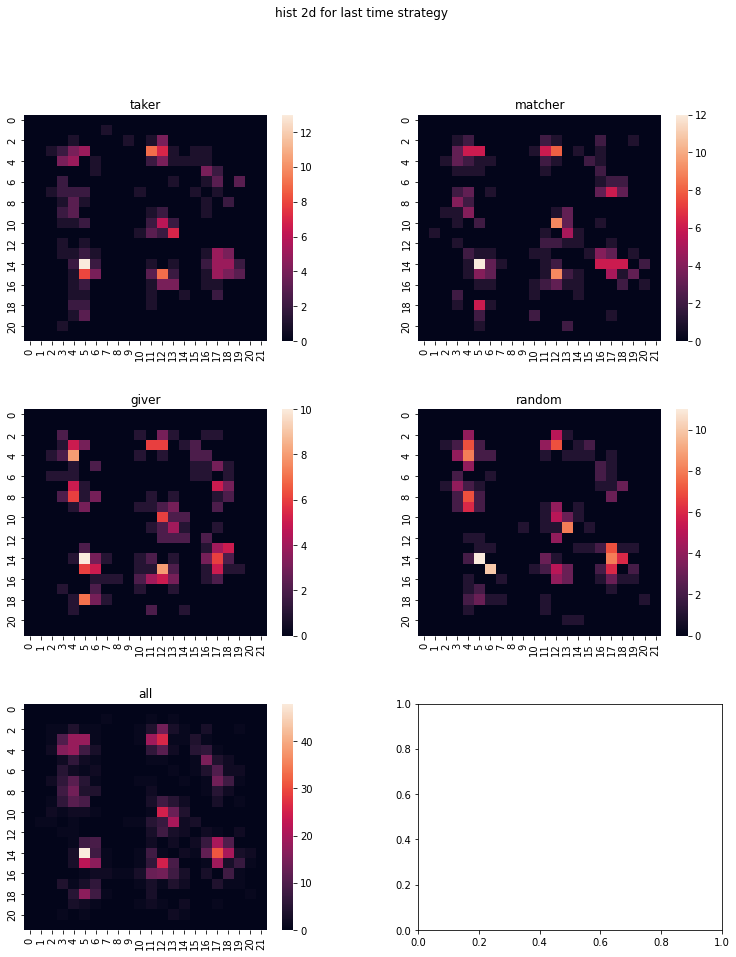

round 10


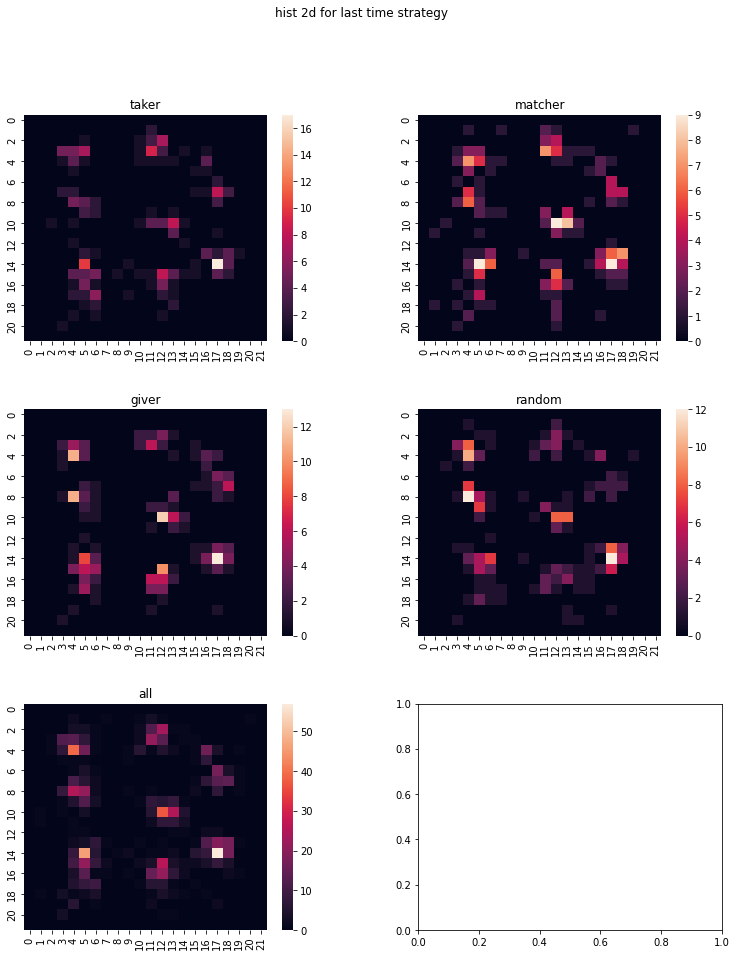

round 20


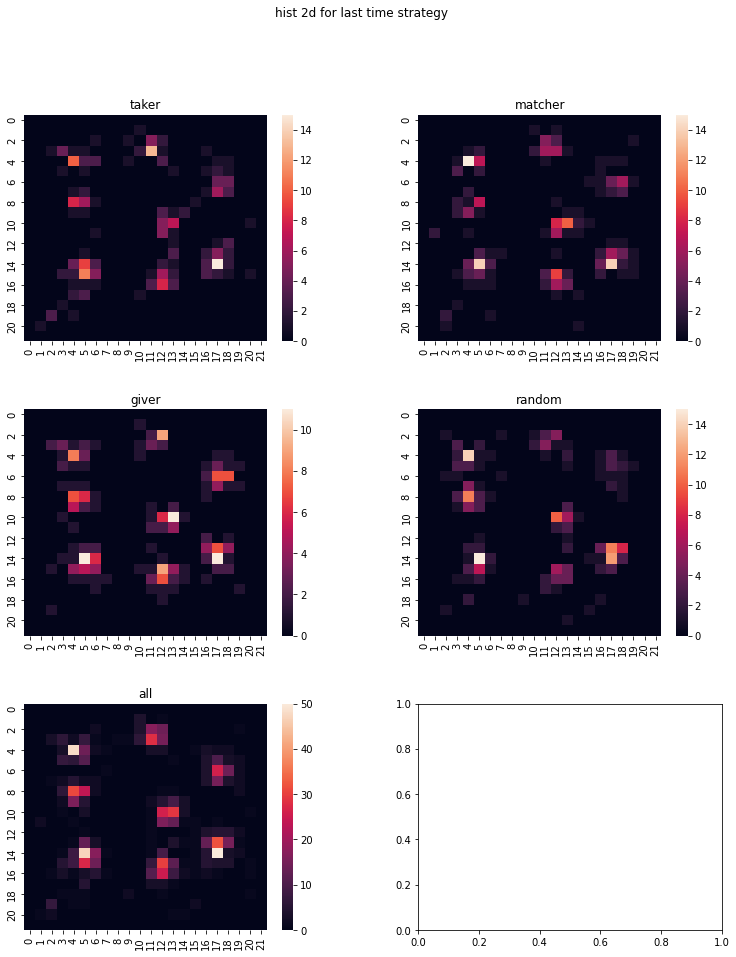

round 30


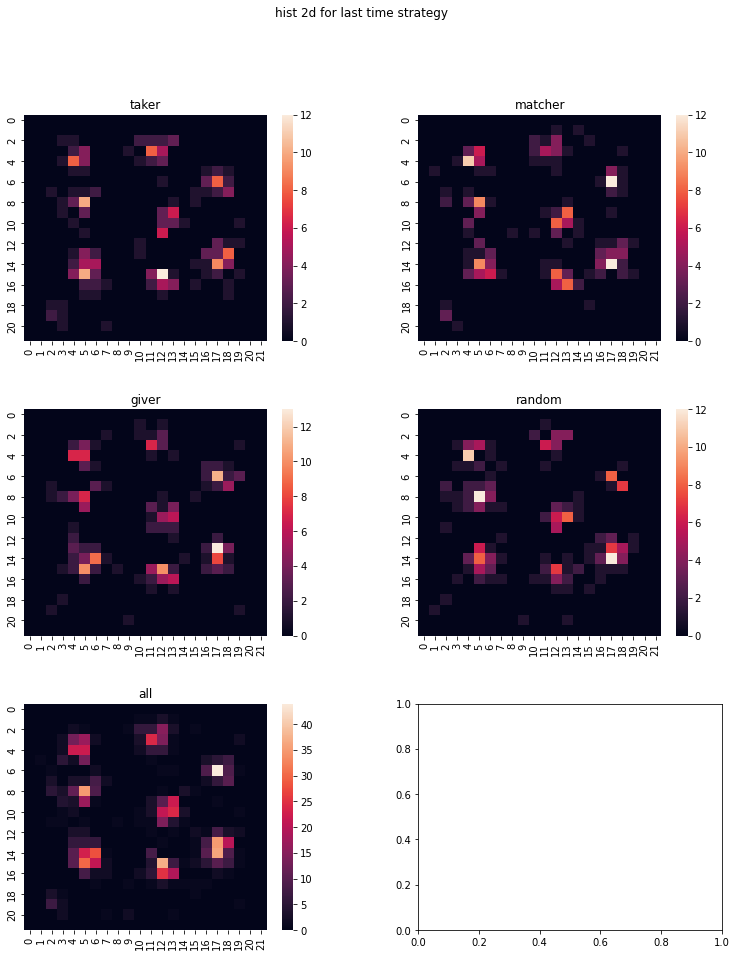

round 40


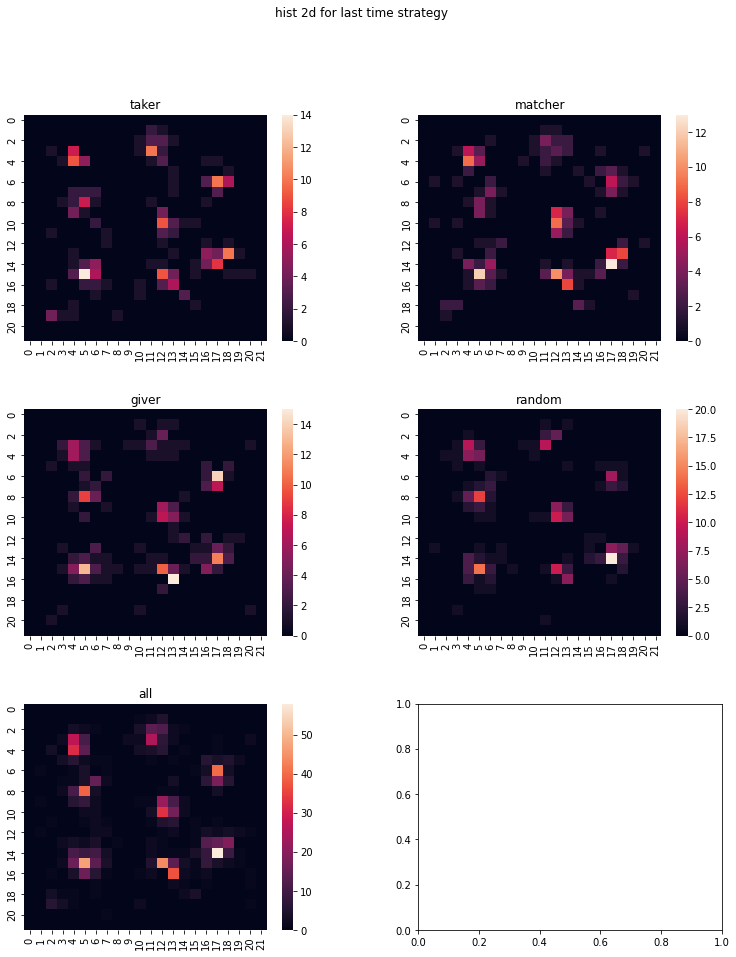

round 50


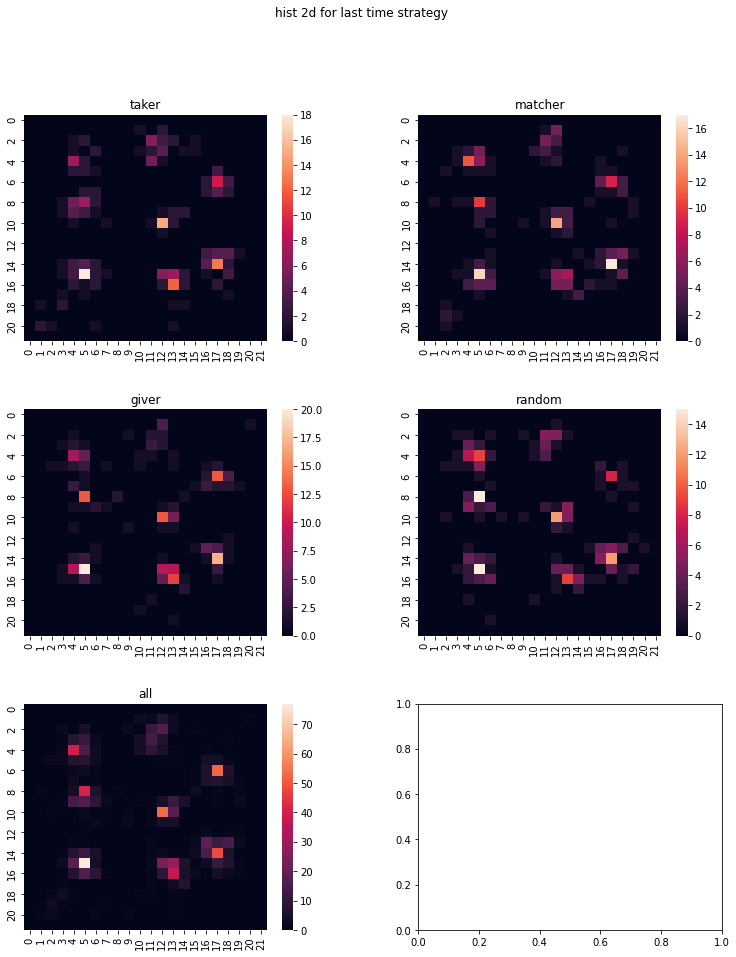

round 60


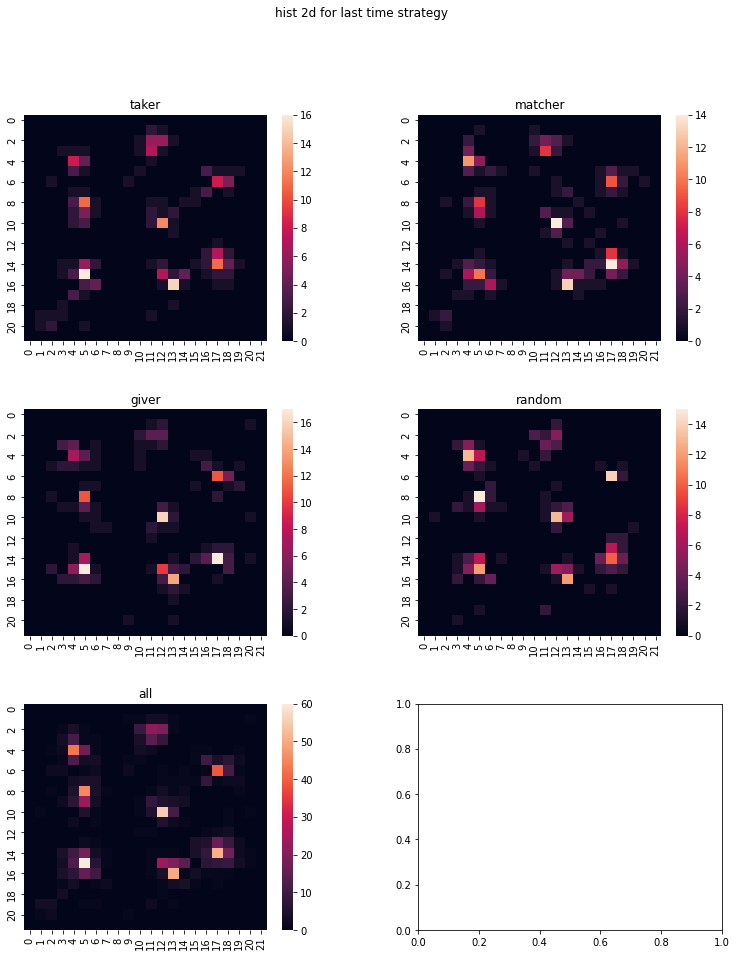

round 70


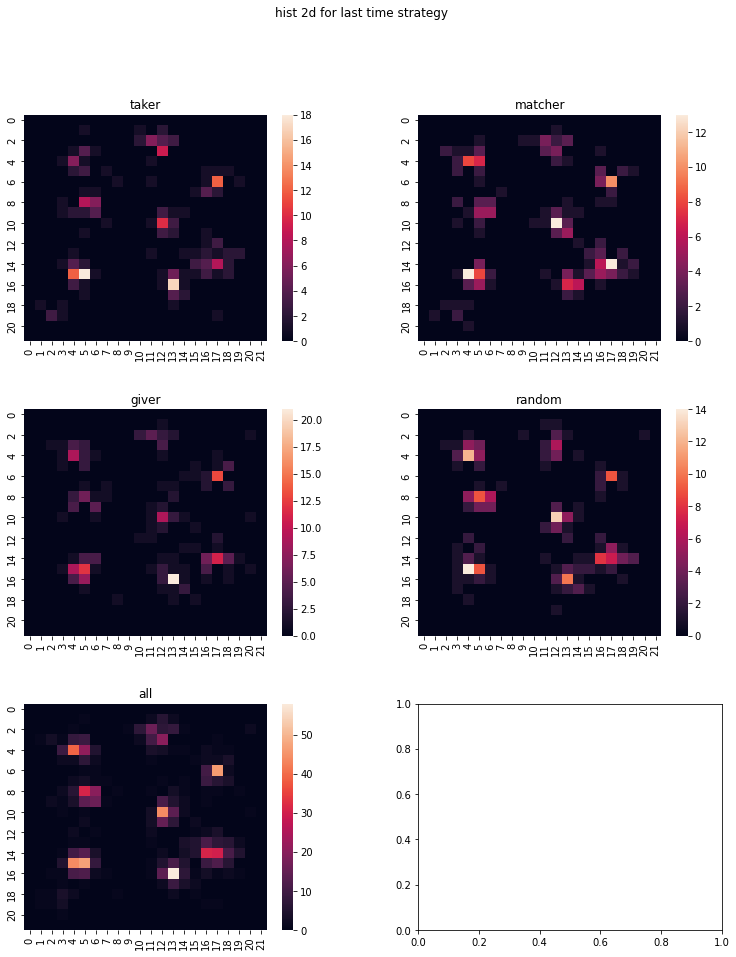

round 80


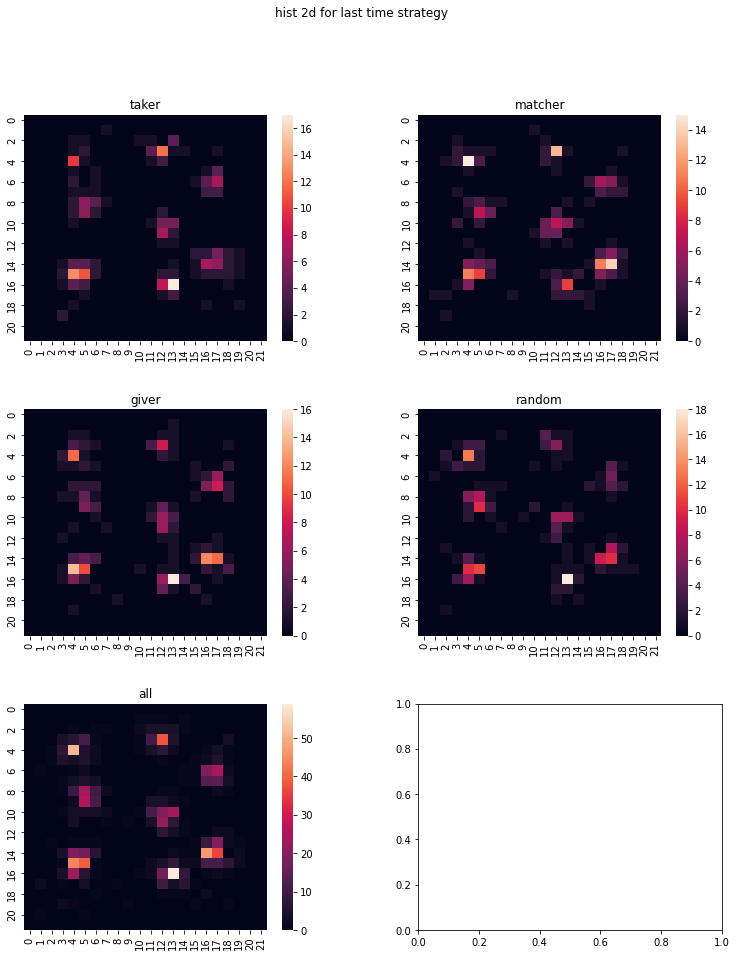

round 90


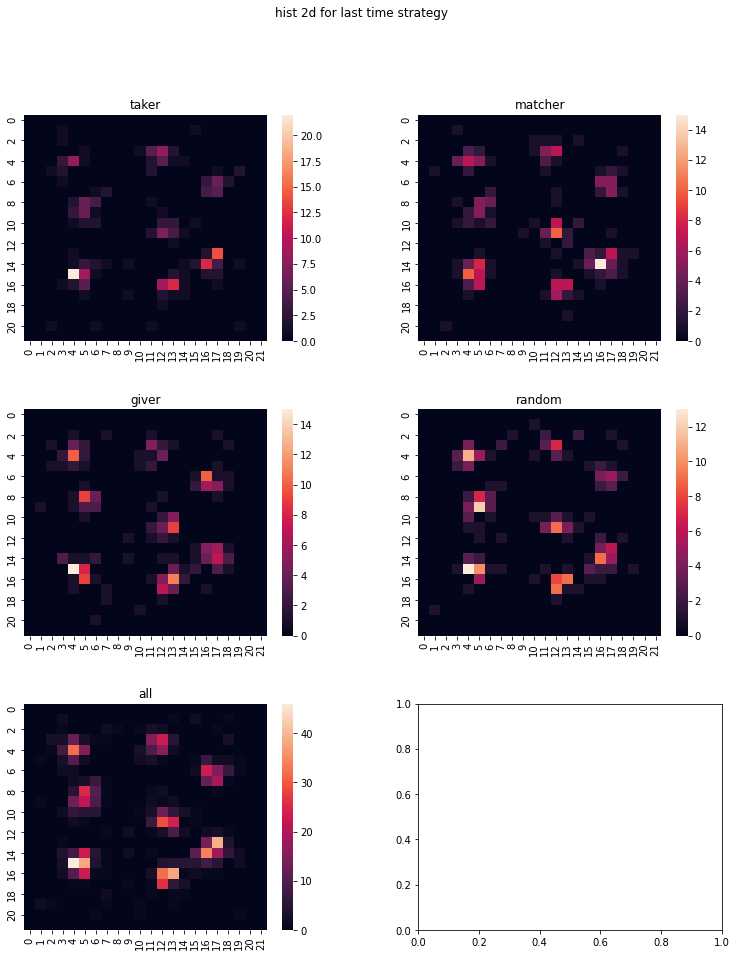

round 100


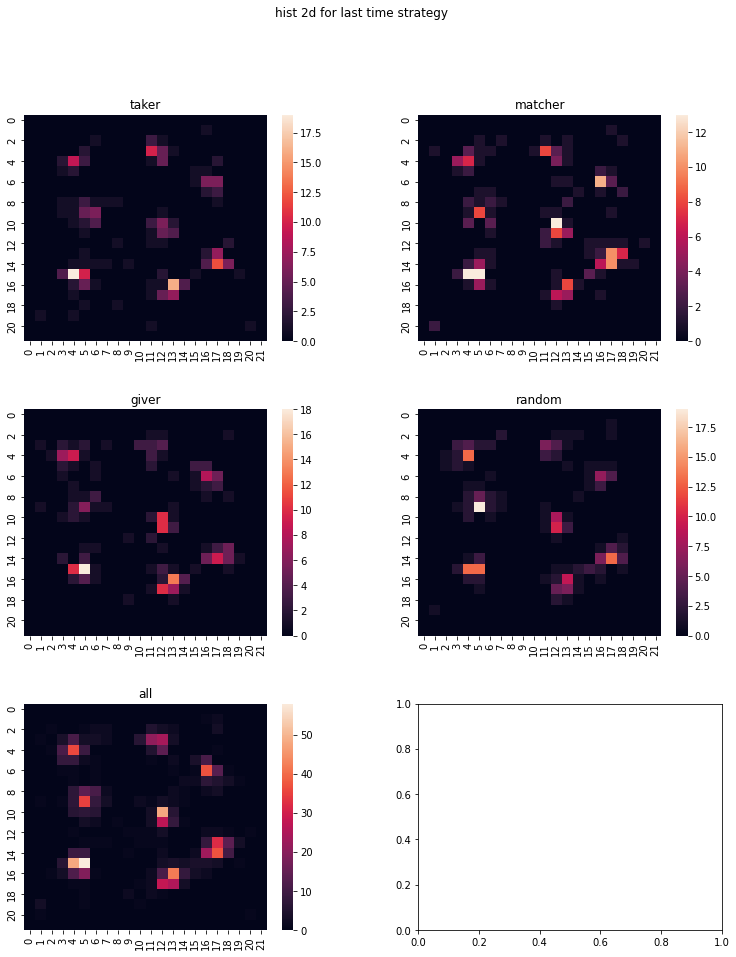

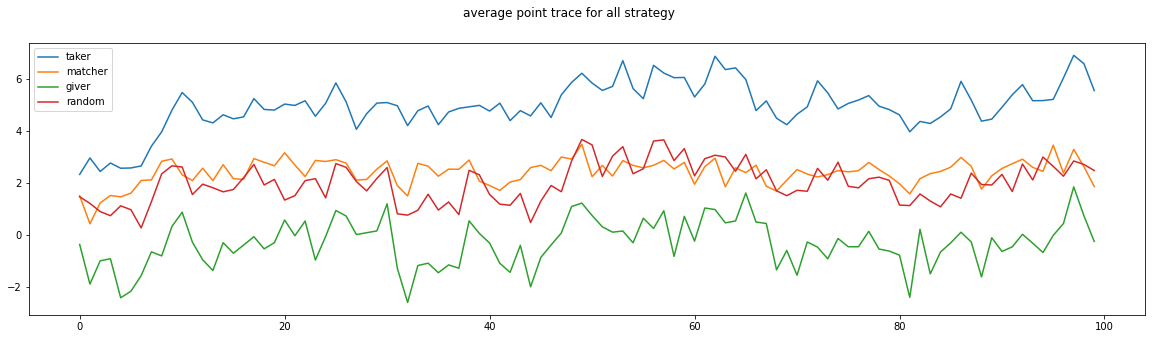

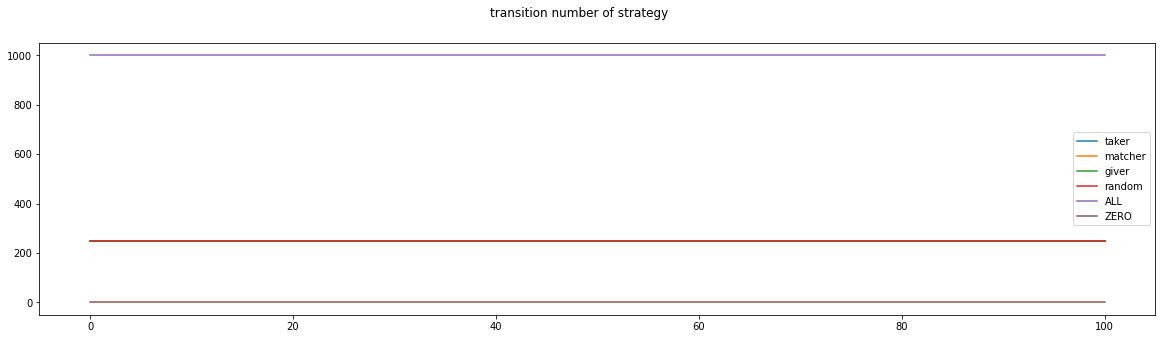

In [4]:
#   デフォルト条件
simulator = Simulator()  #   SQR=20, AGENT_NUM=1000, ASSEMBLY_PARAM=1, PRESSHURE_2_CENTER=0.01, STRATEGY_SHIFT_MAX_RATE=0, TMGR_WAIGHT=[1/4,1/4,1/4,1/4], PENALTY_LINE=None, INITIALIZE_RUN=100
simulator.run_and_plot_template(ROUND=100)

initialising.....
**********
initialize done
round 0


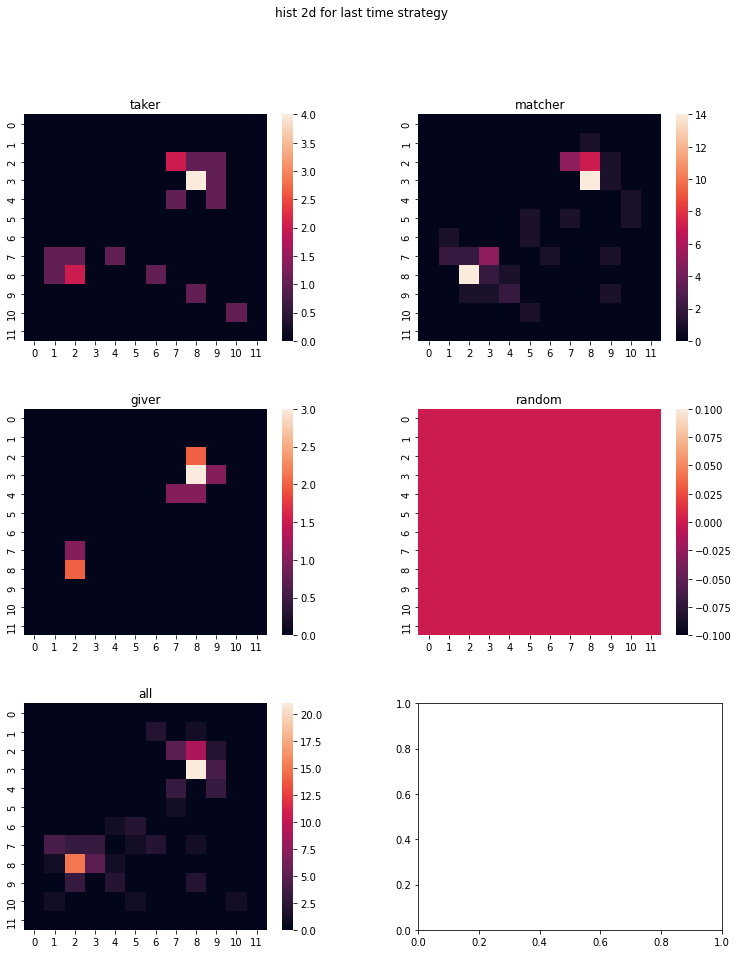

round 100


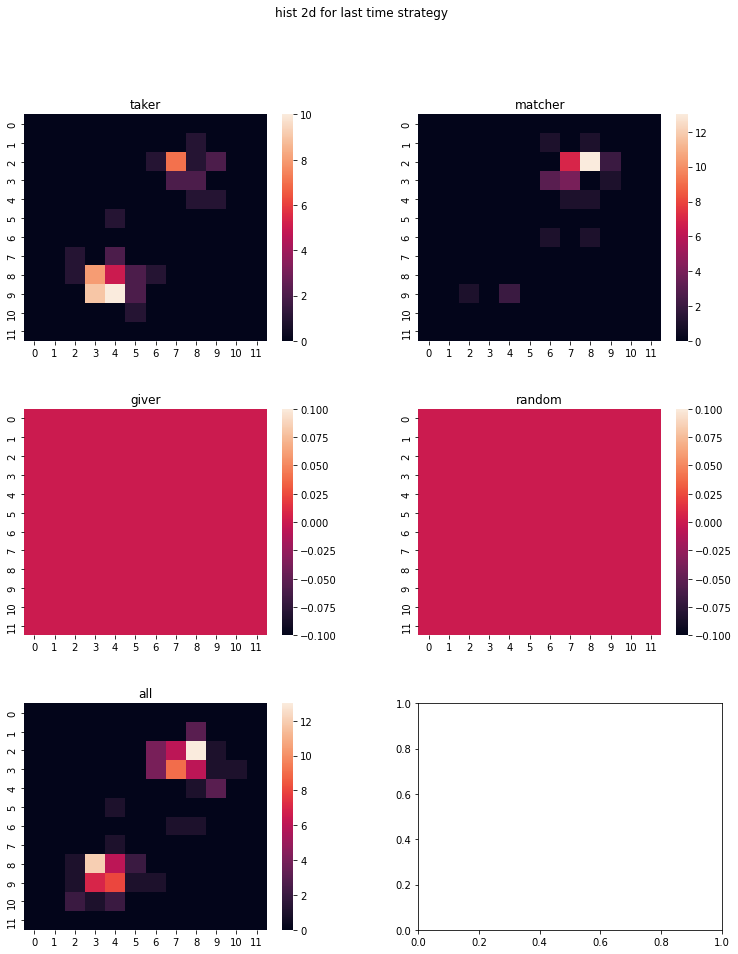

round 200


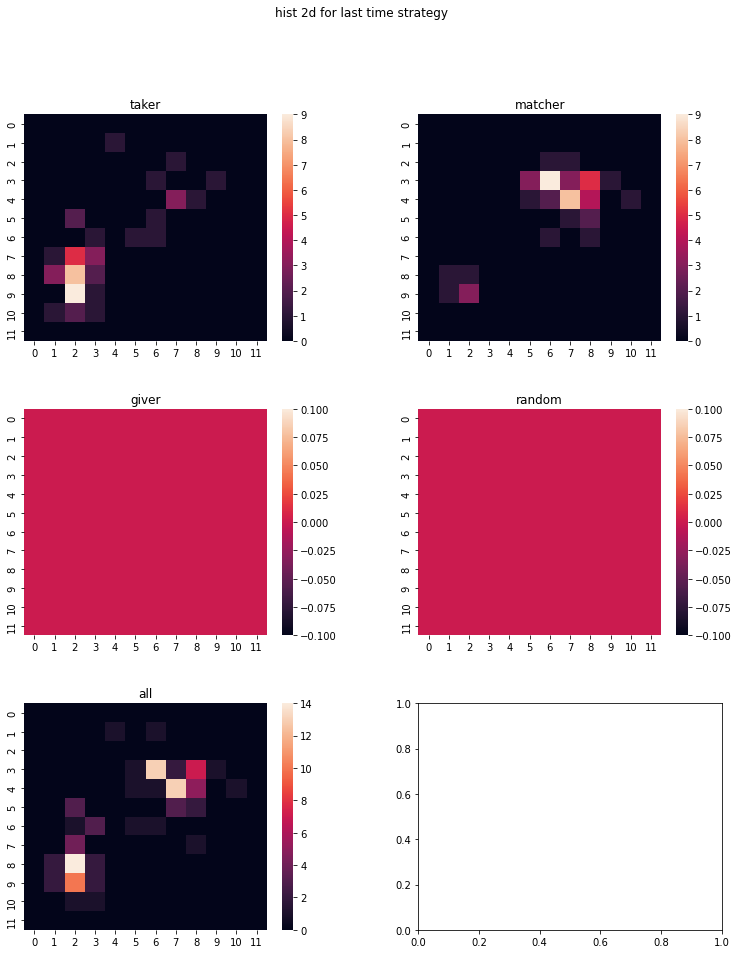

round 300


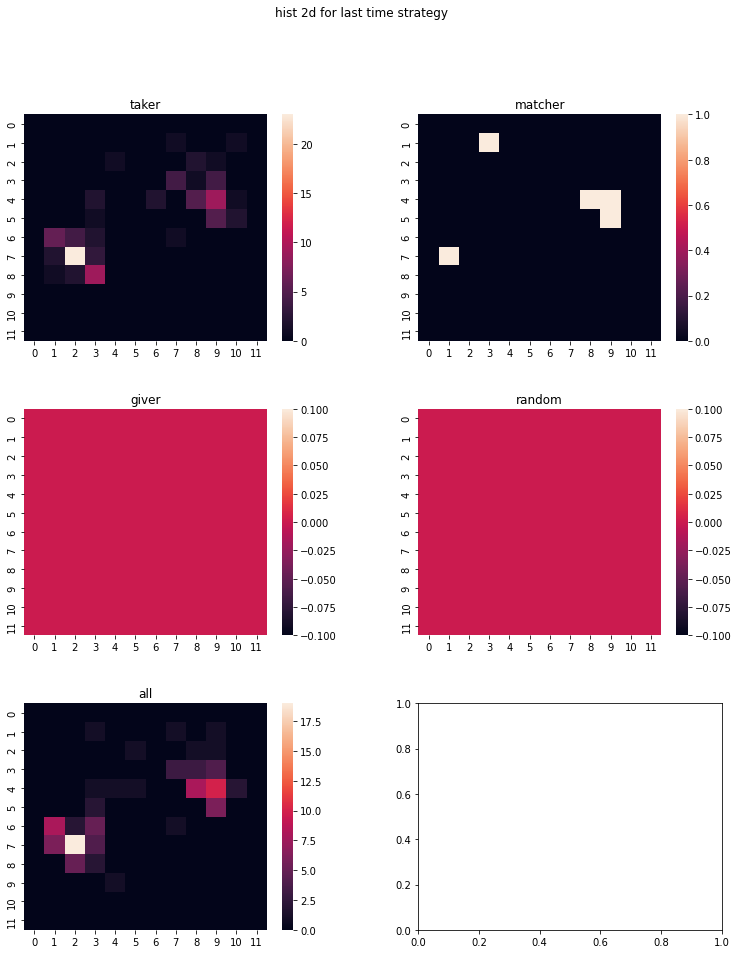

round 400


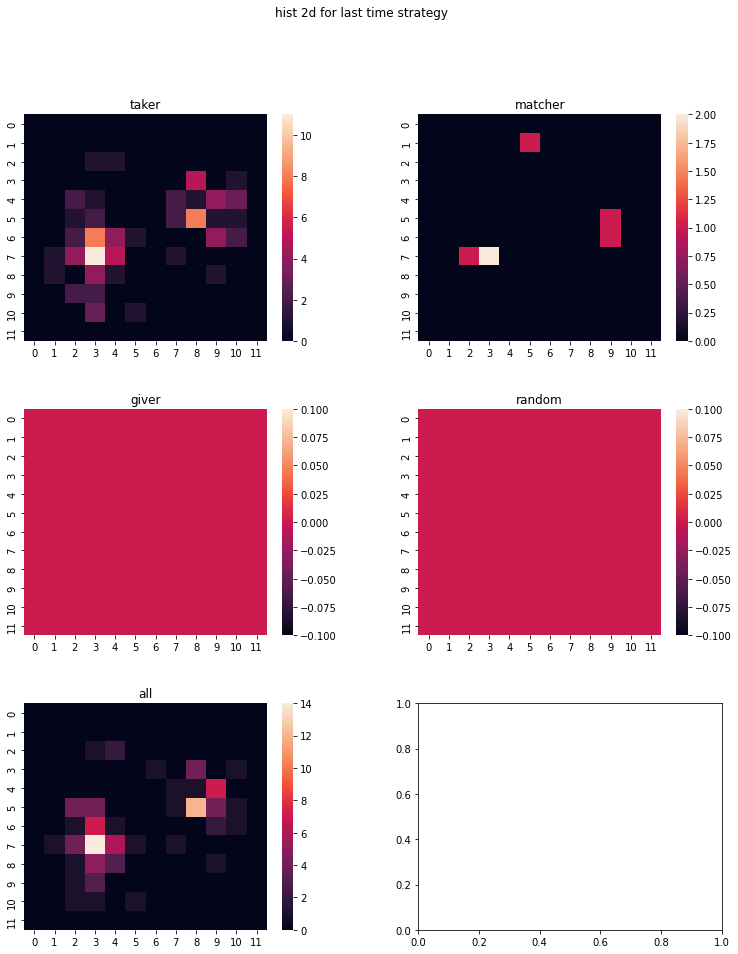

round 500


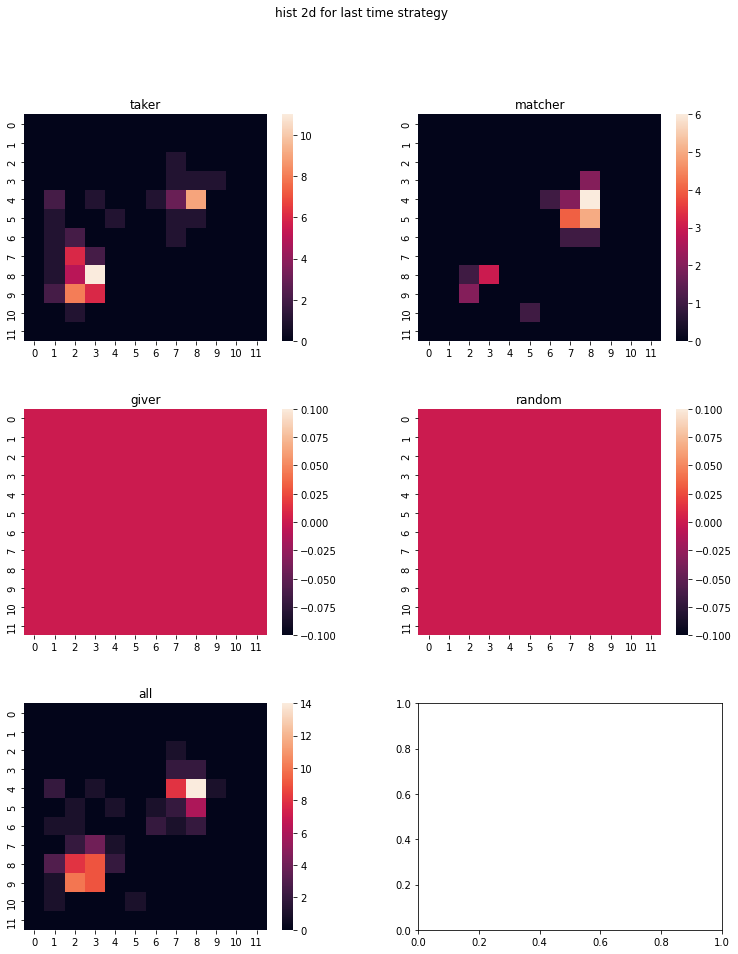

round 600


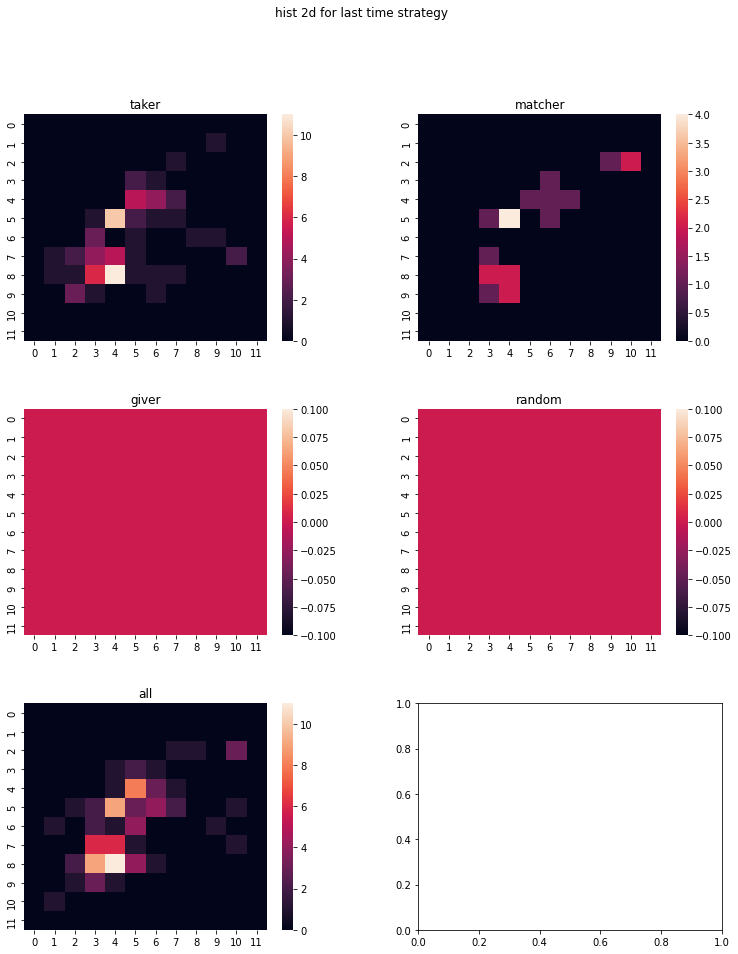

round 700


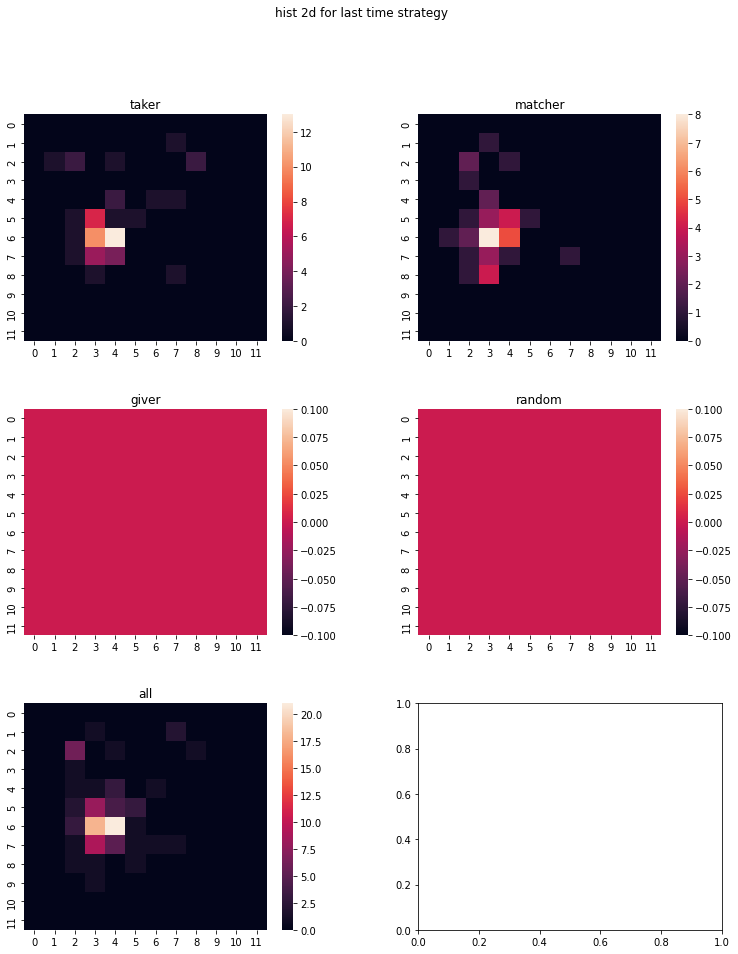

round 800


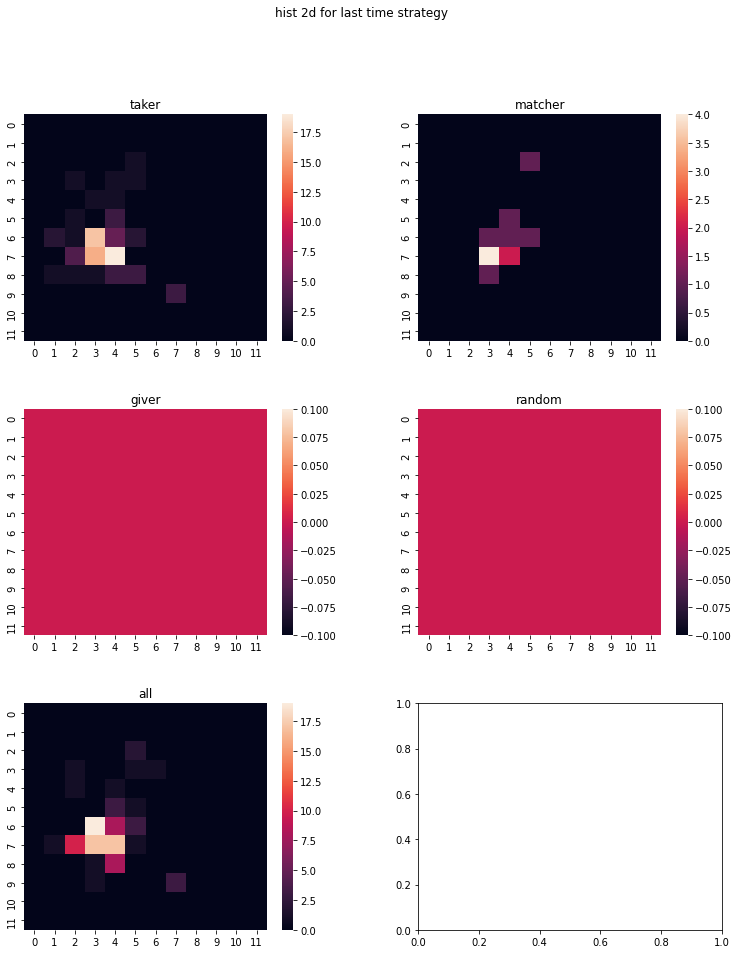

round 900


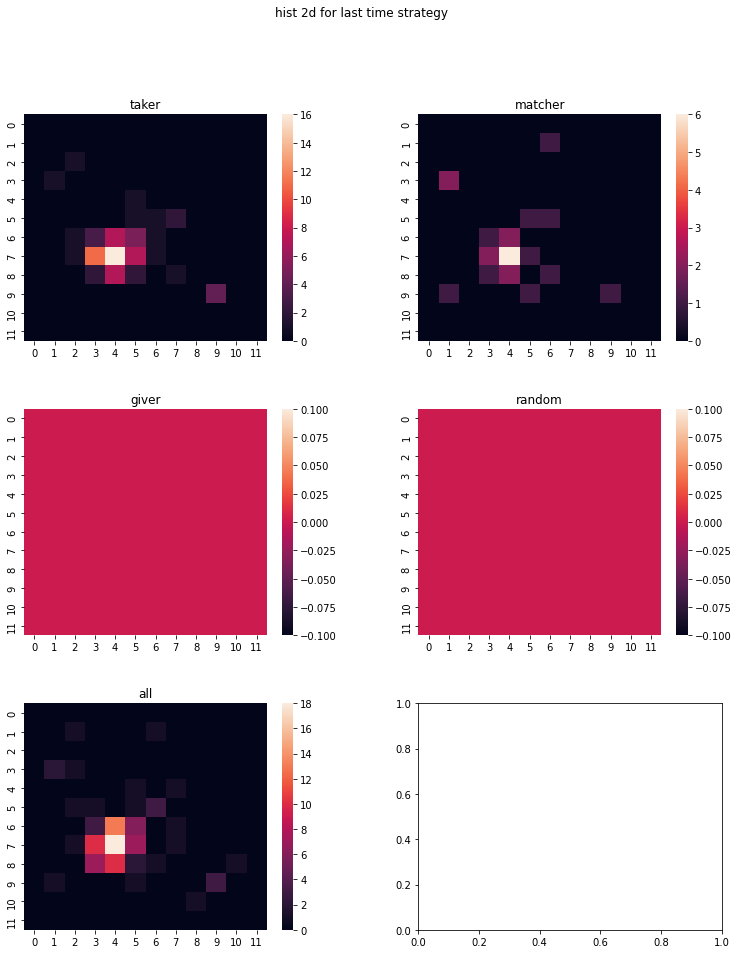

round 1000


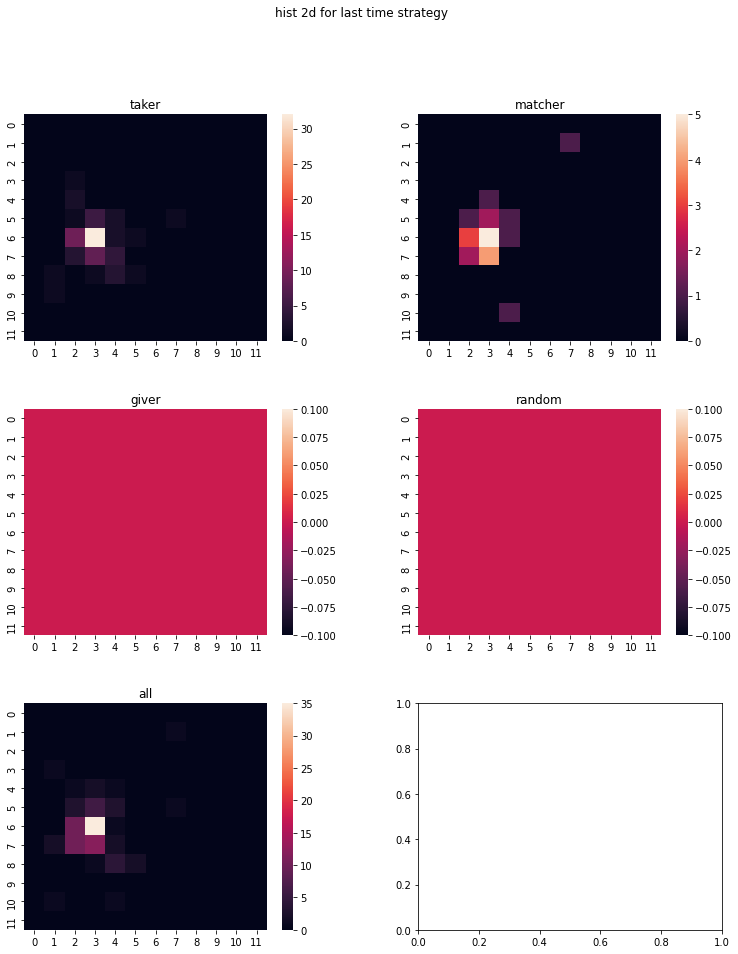

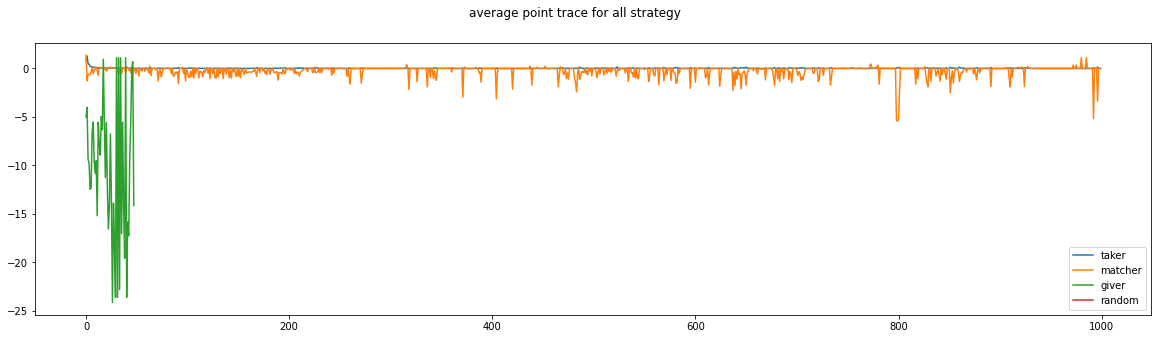

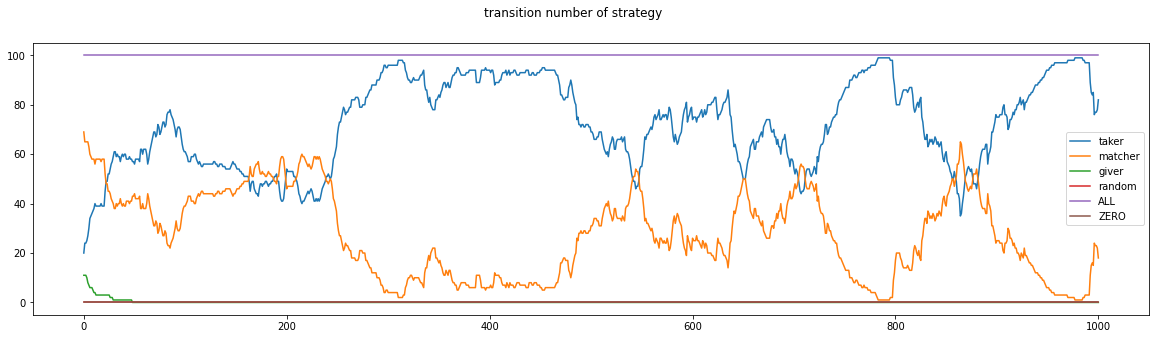

In [17]:
#   SQR=20, AGENT_NUM=1000, ASSEMBLY_PARAM=1, PRESSHURE_2_CENTER=0.01, STRATEGY_SHIFT_MAX_RATE=0, TMGR_WAIGHT=[1/4,1/4,1/4,1/4], PENALTY_LINE=None, INITIALIZE_RUN=100
simulator = Simulator(SQR=10, AGENT_NUM=100, STRATEGY_SHIFT_MAX_RATE=0.1, TMGR_WAIGHT=[0.2,0.7,0.1,0.0], PENALTY_LINE=(1/3,5), INITIALIZE_RUN=100)
simulator.run_and_plot_template(ROUND=1000)